# First optimization using NRV

In this tutorial, NRV optimization formalism is illustrated through a complete example.

## Context

The objective of this optimization is to maximize the fibre recruitment with a minimum 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import csv


sys.path.append("../")
import nrv
test_name = "Tutorial_5"


dir_res = f"./{test_name}/"
if not os.path.isdir(dir_res):
    os.mkdir(dir_res)

nerve_file = dir_res + "nerve.json"
axon_file = dir_res + "myelinated_axon.json"

- Nerve definition

In [2]:
outer_d = 5 # mm
nerve_d = 300 # um
nerve_l = 10000 # um

fasc1_d = 250 # um
fasc1_y = 0
fasc1_z = 0
n_ax1 = 100


start = 1
I_cathod = 40
I_anod = I_cathod/5
T_cathod = 60e-3
T_inter = 40e-3

life_d = 25
life_length = 1000
life_y_c_0 = fasc1_y
life_z_c_0 = fasc1_z


In [3]:
axon_1 = nrv.myelinated(L=nerve_l, d=10, y=50, z=0)
print(axon_1.L)
LIFE_stim0 = nrv.FEM_stimulation()
LIFE_stim0.reshape_outerBox(5)
LIFE_stim0.reshape_nerve(nerve_d, nerve_l)
LIFE_stim0.reshape_fascicle(fasc1_d)
life_x_0_offset = (nerve_l-life_length)/2
elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

stim0 = nrv.stimulus()
stim0.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)
LIFE_stim0.add_electrode(elec_0, stim0)

axon_1.attach_extracellular_stimulation(LIFE_stim0)

axon_1.get_electrodes_footprints_on_axon()
_ = axon_1.save(save=True, fname=axon_file, extracel_context=True)
axon_1()["V_mem"]
del axon_1

10000
NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 13614
NRV INFO: Number of elements : 97031
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 4.9561591148376465 s


In [4]:

nerve_1 = nrv.nerve(length=nerve_l, diameter=nerve_d, Outer_D=outer_d)

axons_diameters, axons_type, M_diam_list, U_diam_list = nrv.create_axon_population(n_ax1, percent_unmyel=0, M_stat="Ochoa_M", U_stat="Ochoa_U",)


fascicle_1 = nrv.fascicle(ID=0)      #we can add diameter here / no need to call define_circular_contour (not tested)
fascicle_1.define_circular_contour(fasc1_d)
fascicle_1.fill_with_population(axons_diameters, axons_type, fit_to_size=True,delta=5)
fascicle_1.generate_random_NoR_position()
nerve_1.add_fascicle(fascicle=fascicle_1, y=fasc1_y, z=fasc1_z)

NRV INFO: On 100 axons to generate, there are 100 Myelinated and 0 Unmyelinated
NRV INFO: Axon packing initiated. This might take a while...


100%|██████████| 20000/20000 [00:01<00:00, 13540.90it/s]

NRV INFO: Packing done!


 - Stimulation context

NRV INFO: From Fascicle 0: Electrode/Axons overlap, 3 axons will be removed from the fascicle
NRV INFO: 100 axons remaining
NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 13614
NRV INFO: Number of elements : 96998
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 5.120193958282471 s


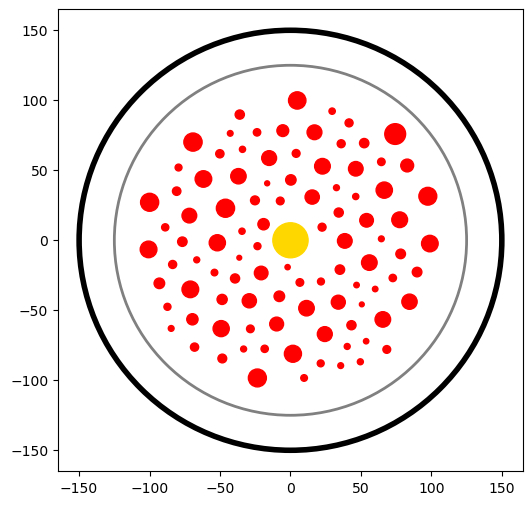

In [5]:

# LIFE in neither of the two fascicles
LIFE_stim0 = nrv.FEM_stimulation()
life_x_0_offset = (nerve_l-life_length)/2
elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

stim0 = nrv.stimulus()
stim0.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)
LIFE_stim0.add_electrode(elec_0, stim0)
nerve_1.attach_extracellular_stimulation(LIFE_stim0)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve_1.plot(ax)

nerve_1.compute_electrodes_footprints()
_ = nerve_1.save(fname=nerve_file, extracel_context=True)

## Optimization



In [6]:
np.random.seed(seed=10)
## Cost function definition
static_context = axon_file

fname0 = dir_res + "/energy_optim_pso_biphasic.json"
fname2 = dir_res + "/energy_optim_pso_spline2pts.json"

costfname0 = dir_res + "/energy_cost_biphasic.csv"
costfname2 = dir_res + "/energy_cost_spline2pts.csv"

t_sim = 5
t_start = 1
t_end = 0.5
I_max_abs = 100
t_bound = (0, t_end)
I_bound = (-I_max_abs, 0)
duration_bound = (0.01, 0.5)

def check_fname(fname):
    if os.path.isfile(fname):
        for i in range(len(fname)):
            if fname[-i-1] == ".":
                try:
                    fname = fname[:-i-2] + str(1+int(fname[-i-2])) + fname[-i-1:]
                except:
                    fname = fname[:-i-1] + "0" + fname[-i-1:]
        return check_fname(fname)
    return fname

def cost_position_saver(data, file_name='document.csv'):
    save = [str(data['cost'])]
    position = data['position']
    dim = len(position)
    for i in range(dim):
        save += [position[i]]
    with open(file_name,'a', newline='') as fd:
        writer = csv.writer(fd)

### Cost Evaluation

The `cost_evaluaiton` is a function or a callable class computing a cost from a simulation `results`.

 - A typical cost evaluation function should :

        Parameters
        results     : sim_results
            output of a simulation
        kwargs      : dict
            optional parameters of the cost evaluation

        Returns
        cost        :float | int
            number of spike in the v_mem part



A few cost evaluations class are already implemented in NRV compatible with algebraical operations.


In [7]:
costR = nrv.recrutement_count_CE(reverse=True)
costC = nrv.stim_energy_CE()

cost_evaluation = costR + 0.01 * costC


In [8]:

kwarg_sim = {
    "return_parameters_only":False,
    "save_results":False,
    "postproc_script":"is_excited",
    "dt":0.002,
}

pso_kwargs = {
    "maxiter" : 50,
    "n_particles" : 20,
    "opt_type" : "local",
    "options": {'c1': 0.45, 'c2': 0.45, 'w': 0.75, 'k': 2, 'p': 1},
    "bh_strategy": "reflective",
}

In [9]:
# Problem definition
test_prob = nrv.Problem(save_problem_results=False)
test_prob.optimizer = nrv.PSO_optimizer()


## first optim (biphasic pulse)
if nrv.MCH.do_master_only_work():
    print("first optim (biphasic pulse)")
context_modifier0 = nrv.biphasic_stimulus_CM(start=t_start, I_cathod="0", T_cathod=0.1*t_end, I_anod=0)
my_cost0 = nrv.CostFunction(
    static_context=static_context,
    context_modifier=context_modifier0,
    cost_evaluation=cost_evaluation,
    kwargs_S=kwarg_sim,
    t_sim=t_sim,
    saver=cost_position_saver,
    file_name=costfname0,
)
bounds0 = (
    (0, I_max_abs),
)
pso_kwargs0 = pso_kwargs
pso_kwargs0.update({"dimensions" : 1, "bounds" : bounds0, "comment":"pulse"})

test_prob.costfunction = my_cost0
res0 = test_prob(problem_fname=fname0, **pso_kwargs0)


first optim (biphasic pulse)


pyswarms.single.general_optimizer: 100%|██████████|2/2, best_cost=7.79e-5
